Run cells one by one, enter huggingface token when asked.


Account should be able to freely access: https://huggingface.co/CompVis/stable-diffusion-v1-4

In [ ]:
!pip install diffusers transformers gradio scipy ftfy "ipywidgets>=7,<8"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-j1pd7bte
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-j1pd7bte
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=45e9f55edf83b531f83ac617d9b129f14b10f4f2586daab20e35c23b6cb49c77
  Stored in directory: /tmp/pip-ephem-wheel-cache-cnd_id1d/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
  import torch
  import numpy as np
  import cv2
  import PIL
  from segment_anything import SamPredictor, sam_model_registry
  from PIL import Image
  import matplotlib.pyplot as plt
  import gradio as gr

  # Download SAM model checkpoint (can also upload to colab if you have it)
  !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  # Load SAM
  sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
  sam.to("cuda")
  predictor = SamPredictor(sam)


--2025-07-01 17:25:37--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.111, 13.35.37.90, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   319MB/s    in 1.1s    

2025-07-01 17:25:39 (319 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [5]:
def generate_sam_mask(input_image, input_point):
    image_np = np.array(input_image)
    predictor.set_image(image_np)

    input_point = np.array([input_point])
    input_label = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=False,
    )

    return Image.fromarray((masks[0] * 255).astype(np.uint8))  # single-channel mask

In [ ]:
from diffusers import  StableDiffusionXLInpaintPipeline
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load SDXL inpainting pipeline
pipe = StableDiffusionXLInpaintPipeline.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    variant="fp16" if device == "cuda" else None,
    use_safetensors=True,
).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [7]:
# Load image
image = Image.open("test6.jpg").convert("RGB")
image_np = np.array(image)
predictor.set_image(image_np)

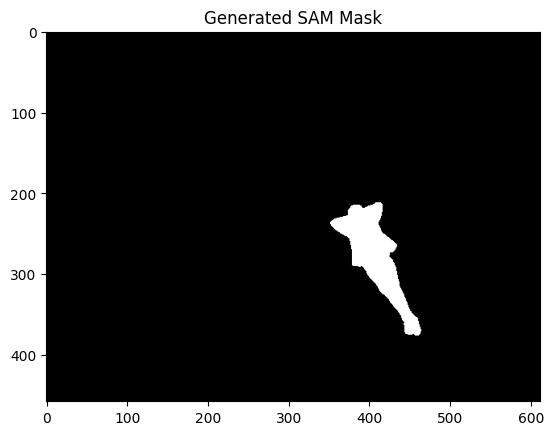

In [8]:
# Step 2: Generate mask using SAM
from PIL import Image, ImageOps
bbox_coords = [300, 200, 500, 400]  # Replace with your values manually

input_box = np.array([bbox_coords])
masks, scores, _ = predictor.predict(box=input_box, multimask_output=True)

# Pick best mask (highest score)
mask = masks[np.argmax(scores)]
mask_image = Image.fromarray((mask * 255).astype(np.uint8))

# # Show the selected mask
plt.imshow(mask_image, cmap='gray')
plt.title("Generated SAM Mask")
plt.show()


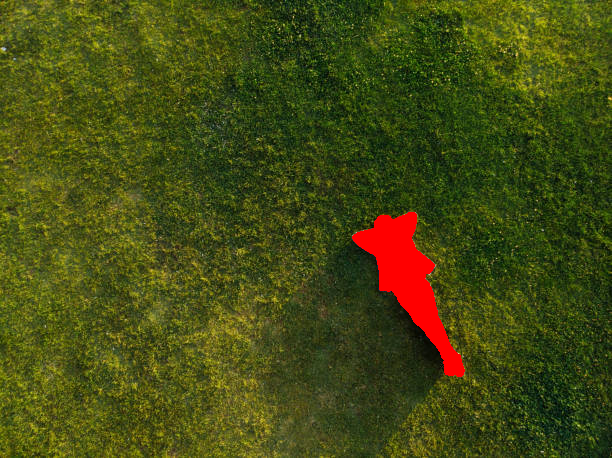

error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [11]:
# Convert images for OpenCV
import cv2
import numpy as np
original_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
mask_cv = np.array(mask_image)
from google.colab.patches import cv2_imshow

# Create a red overlay image
red_overlay = original_bgr.copy()
red_overlay[:, :, 0] = 0   # Zero out Blue
red_overlay[:, :, 1] = 0   # Zero out Green
red_overlay[:, :, 2] = 255 # Max out Red

# Convert mask to 3 channels
mask_3c = cv2.cvtColor(mask_cv, cv2.COLOR_GRAY2BGR) / 255.0

# Blend: apply red only on masked region
final_image = (red_overlay * mask_3c + original_bgr * (1 - mask_3c)).astype(np.uint8)

# Show final result
cv2_imshow( final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


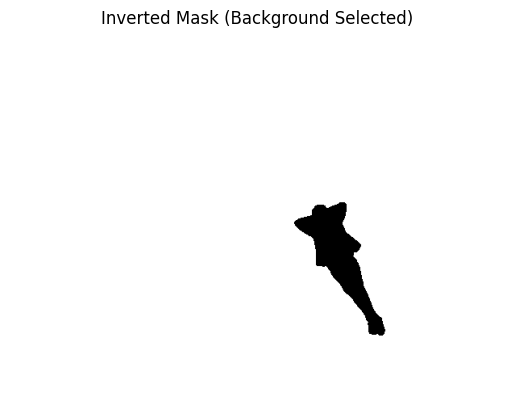

In [12]:
background_mask_image = ImageOps.invert(mask_image)

# Show the background mask
plt.imshow(background_mask_image, cmap='gray')
plt.title("Inverted Mask (Background Selected)")
plt.axis("off")
plt.show()

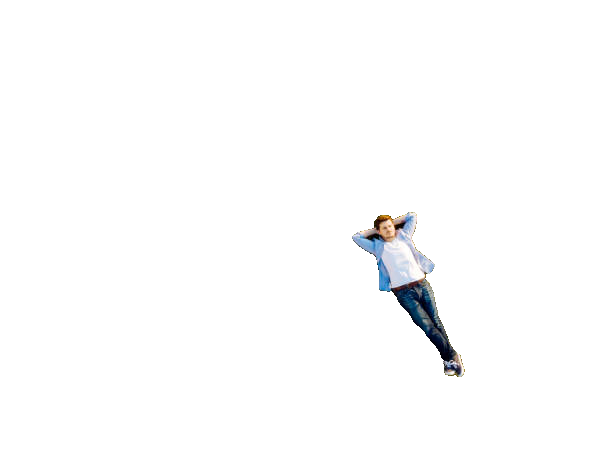

error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [14]:
# Convert images for OpenCV
import cv2
import numpy as np
original_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
mask_cv = np.array(background_mask_image)
from google.colab.patches import cv2_imshow

# Create a red overlay image
red_overlay = original_bgr.copy()
red_overlay[:, :, 0] = 255   # Zero out Blue
red_overlay[:, :, 1] = 255   # Zero out Green
red_overlay[:, :, 2] = 255# Max out Red

# Convert mask to 3 channels
mask_3c = cv2.cvtColor(mask_cv, cv2.COLOR_GRAY2BGR) / 255.0

# Blend: apply red only on masked region
final_image = (red_overlay * mask_3c + original_bgr * (1 - mask_3c)).astype(np.uint8)

# Show final result
cv2_imshow( final_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


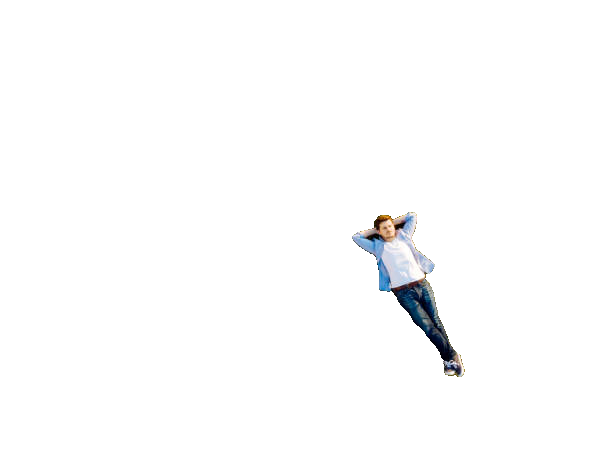

True

In [15]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Assuming:
# original_bgr: your original BGR image
# mask_cv: your background mask (white=background, black=foreground)

# Ensure mask is binary and invert it (if needed, to get foreground mask)
_, mask_binary = cv2.threshold(mask_cv, 127, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(mask_binary)

# Convert original to BGRA (adds alpha channel)
image_bgra = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2BGRA)

# Set alpha channel: foreground opaque (255), background transparent (0)
image_bgra[:, :, 3] = mask_inv

# Show final result (Colab-friendly)
cv2_imshow(image_bgra)

# Save as PNG with transparency
cv2.imwrite("output_transparent.png", image_bgra)


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

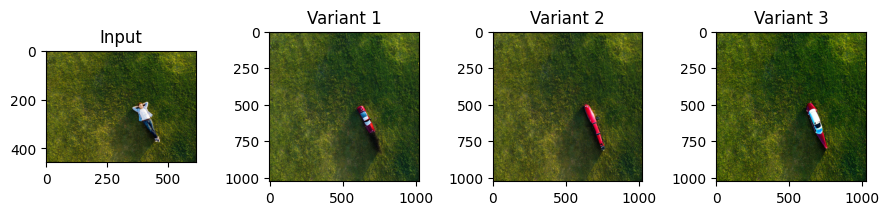

In [ ]:
#Replace Foreground object
num_variants = 3
images = []

for i in range(num_variants):
    generator = torch.Generator(device="cuda").manual_seed(i)  # different seed per run

    result = pipe(
        prompt = "A red car as seen from top view",
        negative_prompt = "blurry, distorted, painting, cartoon, person, human, watermark",
        image=image.convert("RGB").resize((1024, 1024)),
        mask_image=mask_image.convert("L").resize((1024, 1024)),
        generator=generator
    ).images[0]

    images.append(result)


plt.figure(figsize=(9, 3))
plt.subplot(1, num_variants + 1, 1); plt.imshow(image); plt.title("Input")

for i in range(num_variants):
    plt.subplot(1, num_variants + 1, i + 2)
    plt.imshow(images[i])
    plt.title(f"Variant {i+1}")

plt.tight_layout()
plt.show()


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

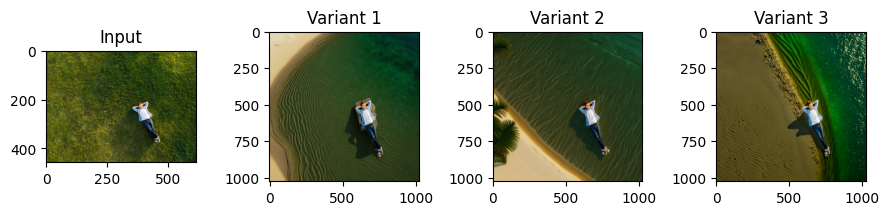

In [ ]:
#Replace Background
num_variants = 3
images = []

for i in range(num_variants):
    generator = torch.Generator(device="cuda").manual_seed(i)  # different seed per run

    result = pipe(
        prompt = "a beautiful photorealistic sandy beach with white sand as seen from top view with blue sea visible in the right corner, natural lighting",
        negative_prompt = "blurry, distorted, painting, person, animal, cartoon, watermark",
        image=image.convert("RGB").resize((1024, 1024)),
        mask_image=background_mask_image.convert("L").resize((1024, 1024)),
        generator=generator
    ).images[0]

    images.append(result)


plt.figure(figsize=(9, 3))
plt.subplot(1, num_variants + 1, 1); plt.imshow(image); plt.title("Input")

for i in range(num_variants):
    plt.subplot(1, num_variants + 1, i + 2)
    plt.imshow(images[i])
    plt.title(f"Variant {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
# Alternative simpler version that handles the tensor size issue
def inpaint_simple_fix(input_dict):
    """
    Simplified version with better error handling
    """
    if input_dict is None:
        return [None] * 3

    # Extract image and mask
    image_pil = input_dict['background']
    mask_pil = input_dict['layers'][0]

    # Convert to RGB
    if image_pil.mode != 'RGB':
        image_pil = image_pil.convert('RGB')

    # Extract mask from alpha channel
    mask_array = np.array(mask_pil)[:, :, 3]  # Alpha channel

    if mask_array.max() == 0:
        return [image_pil] * 3

    # Create proper mask
    mask_pil_processed = Image.fromarray((mask_array > 0).astype(np.uint8) * 255, mode='L')

    # Resize to standard SDXL dimensions (1024x1024 or similar)
    target_size = 1024
    aspect_ratio = image_pil.width / image_pil.height

    if aspect_ratio > 1:  # Wider than tall
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:  # Taller than wide
        new_h = target_size
        new_w = int(target_size * aspect_ratio)

    # Make dimensions multiples of 64
    new_w = (new_w // 64) * 64
    new_h = (new_h // 64) * 64

    image_pil = image_pil.resize((new_w, new_h), Image.LANCZOS)
    mask_pil_processed = mask_pil_processed.resize((new_w, new_h), Image.LANCZOS)

    # Simple inpainting with just one strategy that works
    generator = torch.Generator(device="cuda").manual_seed(42)

    try:
            # Return 3 copies with slight variations
        results = []
        for i in range(3):
            gen = torch.Generator(device="cuda").manual_seed(42 + i)

            var_result = pipe(
                prompt="",
                negative_prompt="object, person, distortion, blurry",
                image=image_pil,
                mask_image=mask_pil_processed,
                generator=gen,
                guidance_scale=5.0 + i * 0.5,
                strength=0.95 + i * 0.01,
                num_inference_steps=25
            ).images[0]
            results.append(var_result)

        return results

    except Exception as e:
        print(f"Inpainting error: {e}")
        return [image_pil] * 3


In [ ]:
# Updated Gradio interface with working ImageEditor
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# SDXL Object Removal Tool ")
    gr.Markdown("### Draw/Paint over the object you want to remove")

    with gr.Row():
        input_editor = gr.ImageEditor(
            label="Draw WHITE over the object to remove",
            type="pil",
            brush=gr.Brush(default_size=20, colors=["#FFFFFF"])
        )

    with gr.Row():
        outputs1 = [gr.Image(label=f"Result {i+1}") for i in range(3)]

    remove_btn1 = gr.Button("Remove Object", variant="primary", size="lg")
    remove_btn1.click(
        fn=inpaint_simple_fix,  # Using the simpler, more reliable version
        inputs=input_editor,
        outputs=outputs1
    )

    gr.Markdown("""
    ### Instructions:
    1. **Upload an image** in the ImageEditor
    2. **Draw WHITE** over the object you want to remove
    3. **Click "Remove Object"**

    **Tips:**
    - Draw slightly beyond object boundaries
    - Use a brush size appropriate for your object
    - The tool automatically resizes images for SDXL compatibility
    """)

demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://b8b37ab21c4e062813.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://b8b37ab21c4e062813.gradio.live


In [ ]:
# Example using Torch Hub
import torch
import torchvision.transforms as transforms
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load model
style_model = torch.hub.load('pytorch/examples', 'fast_neural_style', model='candy').to(device)
style_model.eval()

# Load content image
content_image = Image.open("input.jpg")
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])
content_tensor = preprocess(content_image).unsqueeze(0).to(device)

# Stylize
with torch.no_grad():
    output = style_model(content_tensor).cpu()

# Convert back to PIL
output_image = transforms.ToPILImage()(output[0].clamp(0,255).div(255))
output_image.show()
